# Author

* Joshua Juste Emmanuel Yun Pei NIKIEMA


# INTRODUCTION

Le domaine de **la Vision par ordinateur** avance très rapidement au cours des dernières années. C'est un domaine qui cherche à automatiser les tâches que le système visuel humain peut accomplir, dont la compréhension complète de n'importe quelle scène visuelle. Pour ce faire, plusieurs architectures de réseaux de neurones ont été créés afin d'accomplir une tâche bien spécifique appelé **la segmentation sémantique.**

L'une de ces architectures dont en parle très souvent est le **U-Net**. Ayant fait ces preuves en termes de précision et rapidité, le U-Net est maintenant le plus utilisé pour la segmentation d'images, surtout dans le domaine d'imagerie biomédicale.

Au cours de notre exposé, nous examinerons le concept de la segmentation sémantique et nous allons détailler le fonctionnement, les avantages de **l'architecture U-Net** ainsi que des exemples de ses variantes. Après cela nous allons implémenter **l'Architecture U-NET** avec le jeu de données CarvanaDataset et **les métriques IOU** (Intersection Over Union), **DICE Coefficient et F1 Score.**


# Généralités sur l’architecture U-NET

L’idée principale derrière les **CNNs** est d’apprendre le mappage de fonctionnalités d’une image. Cela fonctionne très bien dans les problèmes de classification lorsque l’image est convertie en un vecteur qui est utilisé après pour la classification. Mais dans la segmentation d’image, on doit non seulement la convertir en vecteur, mais aussi reconstruire une image à partir de ce vecteur. C’est une tâche gigantesque, car il est beaucoup plus difficile de convertir un vecteur en image que l’inverse. Toute l’idée d’U-Net tourne autour de ce problème.

**U-Net**, issu du réseau de **neurones CNN traditionnel**, a été conçu et appliqué pour la première fois en 2015 pour traiter les images biomédicales. Il est capable de localiser et de distinguer les frontières des éléments composant une certaine image en faisant la classification sur chaque pixel.

# Architecture UNET
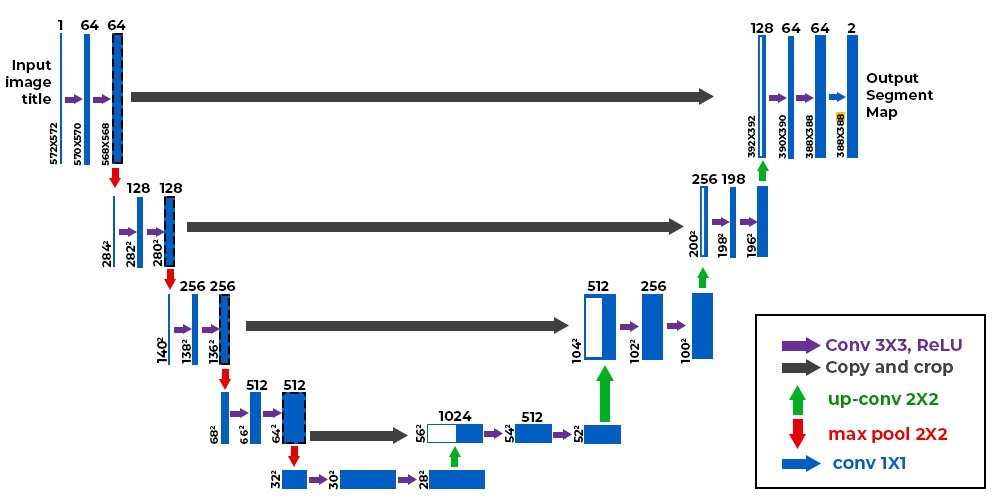

# La segmentation sémantique
**La segmentation sémantique**, aussi appelée classification basée sur les pixels ou bien **prédiction dense**, est une tâche importante dans laquelle on classe chaque pixel d’une image comme appartenant à une classe particulière. Contrairement aux tâches précédentes, les résultats attendus ici ne sont pas seulement des étiquettes et des paramètres de boîte de délimitation. La sortie elle-même est une image à haute résolution dans laquelle chaque pixel est classé dans une classe particulière.

# Les variantes de U-NET
Il existe de nombreuses applications de segmentation d’image en utilisant U-Net et il existe également plusieurs variantes de ce réseau, des versions améliorées ou bien adaptées à des cas bien précis. On prendra quelque exemples:


* UNet++ (UNet plus plus)
* Attention UNet
* Residual UNet
* Recurrent UNet

 # Avantages de U-NET
* Haute précision de segmentation : U-Net est capable de produire des segmentations précises, même pour des images complexes et à faible contraste.
* Polyvalence : U-Net est un modèle général qui peut être utilisé pour une variété de tâches de segmentation d'images, notamment la segmentation médicale, la segmentation satellite et la segmentation d'objets.

* Efficacité : On a un modèle relativement efficace en termes de calcul, ce qui le rend adapté à l'utilisation sur des appareils mobiles ou des systèmes embarqués.

# Etude de cas : Implémentation de U-NET avec le jeu de données CarvanaDataset et des métriques IOU (Intersection Over Union), DICE Coefficient et F1 Score.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from tqdm import tqdm
import numpy as np
from sklearn.metrics import jaccard_score, f1_score
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from PIL import Image
import os

#### Implémentation des opérations de base de U-net

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

### Implémentation de l'Architecture U-Net

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSample, self).__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSample, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)


class SimpleUNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleUNet, self).__init__()
        self.down_convs = nn.ModuleList([
            DownSample(in_channels, 64),
            DownSample(64, 128),
            DownSample(128, 256),
            DownSample(256, 512)
        ])

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convs = nn.ModuleList([
            UpSample(1024, 512),
            UpSample(512, 256),
            UpSample(256, 128),
            UpSample(128, 64)
        ])

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_features = []
        p = x
        for down_conv in self.down_convs:
            down, p = down_conv(p)
            down_features.append(down)

        b = self.bottle_neck(p)

        for up_conv, down_feature in zip(self.up_convs, reversed(down_features)):
            b = up_conv(b, down_feature)

        out = self.out(b)
        return out


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image = torch.rand((1, 3, 256, 256)).to(device)
print(image.shape)
model1 = SimpleUNet(in_channels=3, num_classes=1).to(device)
print(model1(image))

### Implémentation de la classe permettant d'importer les données

In [5]:
class CarvanaDataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        if test:
            self.images = sorted([root_path+"/test_images/"+i for i in os.listdir(root_path+"/test_images/")])
            self.masks = sorted([root_path+"/test_masks/"+i for i in os.listdir(root_path+"/test_masks/")])
        else:
            self.images = sorted([root_path+"/train_images/"+i for i in os.listdir(root_path+"/train_images/")])
            self.masks = sorted([root_path+"/train_masks/"+i for i in os.listdir(root_path+"/train_masks/")])

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)

### Implémentation de la classe servant à faire l'évaluation du modèle

### Entrainement du model

In [6]:
LEARNING_RATE = 0.001
BATCH_SIZE = 16
EPOCHS = 2

In [ ]:
DATA_PATH = "/content/drive/MyDrive/DL_dataCar/data_car"


device = "cuda" if torch.cuda.is_available() else "cpu"
train_dataset = CarvanaDataset(DATA_PATH)

total_length = len(train_dataset)

# Set the seed for reproducibility
generator = torch.Generator().manual_seed(42)

# Specify the lengths for training and validation
train_length = int(0.6 * total_length)
val_length = total_length - train_length

# Perform random split
train_dataset, val_dataset = random_split(train_dataset, [train_length, val_length], generator=generator)

train_dataloader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

In [ ]:
model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()


for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    for idx, img_mask in enumerate(tqdm(train_dataloader)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)

        optimizer.zero_grad()

        loss = criterion(y_pred, mask)

        loss.backward()

        optimizer.step()

        train_running_loss += loss.item()

    train_loss = train_running_loss / (idx + 1)


    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)

            val_running_loss += loss.item()

        val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print("-"*30)

100%|██████████| 22/22 [02:26<00:00,  6.64s/it]

 25%|██▌       | 1/4 [04:29<13:29, 269.84s/it]

------------------------------
Train Loss EPOCH 1: 0.5244
Valid Loss EPOCH 1: 0.4024
------------------------------



100%|██████████| 22/22 [00:31<00:00,  1.44s/it]

 50%|█████     | 2/4 [05:15<04:36, 138.14s/it]

------------------------------
Train Loss EPOCH 2: 0.3904
Valid Loss EPOCH 2: 0.3660
------------------------------



100%|██████████| 22/22 [00:31<00:00,  1.42s/it]

 75%|███████▌  | 3/4 [06:01<01:36, 96.08s/it] 

------------------------------
Train Loss EPOCH 3: 0.5141
Valid Loss EPOCH 3: 0.3904
------------------------------



100%|██████████| 22/22 [00:32<00:00,  1.50s/it]

100%|██████████| 4/4 [06:49<00:00, 102.34s/it]

------------------------------
Train Loss EPOCH 4: 0.3952
Valid Loss EPOCH 4: 0.3739
------------------------------


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/DL_dataCar/models/unet1.pth"
torch.save(model.state_dict(), MODEL_SAVE_PATH)

### Test

100%|██████████| 198/198 [01:52<00:00,  1.76it/s]


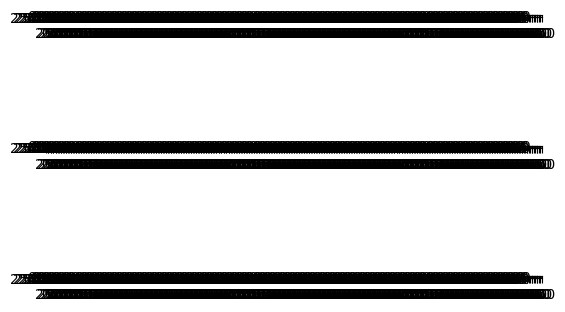

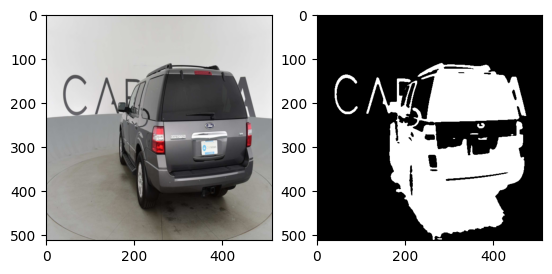

In [ ]:
def pred_show_image_grid(data_path, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))
    image_dataset = CarvanaDataset(data_path, test=True)
    images = []
    orig_masks = []
    pred_masks = []

    for img, orig_mask in tqdm(image_dataset):
        img = img.float().to(device)
        img = img.unsqueeze(0)

        pred_mask = model(img)

        img = img.squeeze(0).cpu().detach()
        img = img.permute(1, 2, 0)

        pred_mask = pred_mask.squeeze(0).cpu().detach()
        pred_mask = pred_mask.permute(1, 2, 0)
        pred_mask[pred_mask < 0]=0
        pred_mask[pred_mask > 0]=1

        orig_mask = orig_mask.cpu().detach()
        orig_mask = orig_mask.permute(1, 2, 0)

        images.append(img)
        orig_masks.append(orig_mask)
        pred_masks.append(pred_mask)

    images.extend(orig_masks)
    images.extend(pred_masks)
    fig = plt.figure()
    for i in range(1, 3*len(image_dataset)+1):
       fig.add_subplot(3, len(image_dataset), i)
       plt.imshow(images[i-1], cmap="gray")
    plt.show()


def single_image_inference(image_pth, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()])

    img = transform(Image.open(image_pth)).float().to(device)
    img = img.unsqueeze(0)

    pred_mask = model(img)

    img = img.squeeze(0).cpu().detach()
    img = img.permute(1, 2, 0)

    pred_mask = pred_mask.squeeze(0).cpu().detach()
    pred_mask = pred_mask.permute(1, 2, 0)
    pred_mask[pred_mask < 0]=0
    pred_mask[pred_mask > 0]=1

    fig = plt.figure()
    for i in range(1, 3):
        fig.add_subplot(1, 2, i)
        if i == 1:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(pred_mask, cmap="gray")
    plt.show()


if __name__ == "__main__":
    SINGLE_IMG_PATH = "/content/drive/MyDrive/DL_dataCar/data_car/test_images/1390696b70b6_08.jpg"
    DATA_PATH = "/content/drive/MyDrive/DL_dataCar/data_car"
    MODEL_PATH = "/content/drive/MyDrive/DL_dataCar/models/unet1.pth"

    device = "cuda" if torch.cuda.is_available() else "cpu"
    pred_show_image_grid(DATA_PATH, MODEL_PATH, device)
    single_image_inference(SINGLE_IMG_PATH, MODEL_PATH, device)

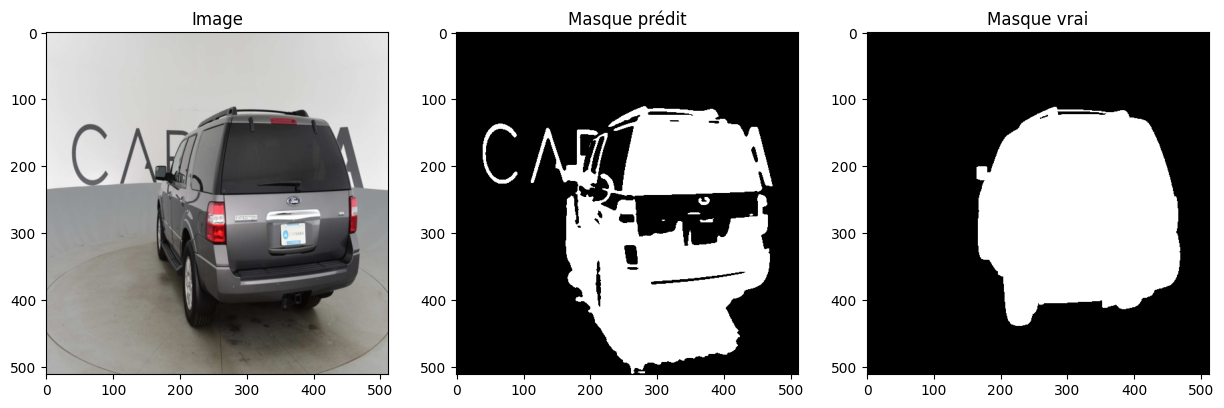

In [8]:
def single_image_inference(image_pth, model_pth, true_mask_pth, device):
    # Charger le modèle
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    # Charger l'image
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()])
    img = transform(Image.open(image_pth)).float().to(device)
    img = img.unsqueeze(0)

    # Prédiction du masque
    pred_mask = model(img)

    # Traitement de l'image et du masque prédit
    img = img.squeeze(0).cpu().detach()
    img = img.permute(1, 2, 0)

    pred_mask = pred_mask.squeeze(0).cpu().detach()
    pred_mask = pred_mask.permute(1, 2, 0)
    pred_mask[pred_mask < 0] = 0
    pred_mask[pred_mask > 0] = 1

    # Charger le masque vrai
    true_mask = transform(Image.open(true_mask_pth)).float().to(device)
    true_mask = true_mask.unsqueeze(0)  # Ajouter une dimension de canal
    true_mask = true_mask.squeeze(0).cpu().detach()
    true_mask = true_mask.permute(1, 2, 0)
    true_mask[true_mask < 0] = 0  # Assurez-vous que le masque vrai est binarisé
    true_mask[true_mask > 0] = 1

    # Affichage des images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title("Image")

    axes[1].imshow(pred_mask, cmap="gray")
    axes[1].set_title("Masque prédit")

    axes[2].imshow(true_mask, cmap="gray")
    axes[2].set_title("Masque vrai")

    plt.show()

device = "cuda" if torch.cuda.is_available() else "cpu"
image_path = "/content/drive/MyDrive/DL_dataCar/data_car/test_images/1390696b70b6_08.jpg"
model_path = "/content/drive/MyDrive/DL_dataCar/models/unet1.pth"
true_mask_path = "/content/drive/MyDrive/DL_dataCar/data_car/test_masks/1390696b70b6_08_mask.gif"

single_image_inference(image_path, model_path, true_mask_path, device)

# Implémenter l'architecture U-Net avec les trois métriques

* IOU (Intersection Over Union)

* DICE Coefficient

* F1 Score

Les métriques Intersection Over Union (IOU), Dice Coefficient et F1 Score sont couramment utilisées pour évaluer la performance des modèles de segmentation d'images, notamment dans des tâches telles que la segmentation sémantique ou la détection d'objets. Ces métriques mesurent la similarité entre les masques prédits par le modèle et les masques de référence (ground truth). Voici des explications détaillées de chacune de ces métriques :

**Intersection Over Union (IOU) :**

L'IOU mesure le degré de chevauchement entre la zone prédite par le modèle et la zone réelle (ground truth). Il est défini comme le rapport entre la surface de l'intersection et celle de l'union entre les deux zones.

La formule mathématique de l'IOU est la suivante :
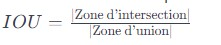




**Dice Coefficient :**

Le Dice Coefficient, aussi appelé F1b (F1 binaire), est une autre mesure de similarité entre les masques prédits et les masques de référence. Il est défini comme le double de la surface de l'intersection divisé par la somme des surfaces des deux régions (prédite et de référence).

La formule mathématique du Dice Coefficient est la suivante :
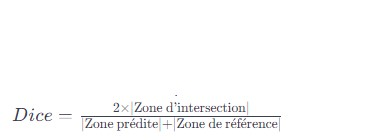

**F1 Score :**

Le F1 Score est une mesure plus générale qui combine la précision et le rappel du modèle. Il est particulièrement utile lorsque les classes à prédire sont déséquilibrées.
Le F1 Score est calculé à partir de la précision (P) et du rappel (R) selon la formule :

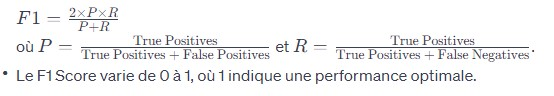

## Evalution

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
MODEL_PATH = "/content/drive/MyDrive/DL_dataCar/models/unet1.pth"

In [ ]:
#model = UNet(in_channels=3, num_classes=1).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# Définir la fonction d'évaluation
def evaluate(model, dataloader):
    model.eval()
    iou_scores = []
    f1_scores = []
    dice_scores = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.float().to(device), targets.float().to(device)

            outputs = model(inputs)
            predictions = (outputs > 0.5).float()  # Appliquer un seuil de 0.5

            # Convertir les cibles en masques binaires
            targets = (targets > 0.5).float()

            # Calculer la confusion matrix
            cm = confusion_matrix(targets.view(-1).cpu(), predictions.view(-1).cpu())

            # Calculer True Positives, False Positives, False Negatives
            tp = torch.sum((targets == 1) & (predictions == 1)).item()
            fp = torch.sum((targets == 0) & (predictions == 1)).item()
            fn = torch.sum((targets == 1) & (predictions == 0)).item()

            # Calculer F1-Score
            # precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            # recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            # f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            # f1_scores.append(f1)
            # Calculer F1-Score en utilisant la fonction f1_score de scikit-learn
            f1 = f1_score(targets.view(-1).cpu().numpy(), predictions.view(-1).cpu().numpy())
            f1_scores.append(f1)

            # Calculer IOU
            iou = tp / (tp + fp + fn)
            iou_scores.append(iou)

            # Calculer Dice Coefficient
            dice = (2 * tp) / (2 * tp + fp + fn)
            dice_scores.append(dice)

    mean_iou = np.mean(iou_scores)
    mean_f1 = np.mean(f1_scores)
    mean_dice = np.mean(dice_scores)

    return mean_iou, mean_f1, mean_dice

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

mean_iou, mean_f1, mean_dice = evaluate(model, val_dataloader)

print(f"IOU: {mean_iou}, F1-Score: {mean_f1}, Dice Coefficient: {mean_dice}")

100%|██████████| 15/15 [00:38<00:00,  2.57s/it]

IOU: 0.47184349966733935, F1-Score: 0.6396674257061378, Dice Coefficient: 0.6396674257061377


# CONCLUSION
En résumé, l'U-Net a joué un rôle majeur dans le domaine de la segmentation d'images, offrant une approche puissante et adaptable pour des applications variées, de la médecine à la vision par ordinateur générale. Son succès repose sur sa capacité à combiner des informations à différentes échelles spatiales tout en préservant les détails fins, faisant de cette architecture une référence dans le domaine de la segmentation sémantique.


#### Lien kaggle vers le dataset complet : https://www.kaggle.com/c/carvana-image-masking-challenge